#### 样本特征值（像元值）提取

In [63]:
import geopandas as gpd
import rasterio as rio
from rasterio import mask
import matplotlib.pyplot as plt
import numpy as np

In [64]:
path_roi_water = 'data/Section-7/roi_water.gpkg'
path_roi_veg = 'data/Section-7/roi_vegetation.gpkg'
path_roi_building = 'data/Section-7/roi_building.gpkg'
path_roi_soil = 'data/Section-7/roi_soil.gpkg'
path_rsimg = 'data/Section-7/s2_chenggong_20200411_6bands_20m.tif'


In [65]:
## 读入矢量数据
roi_wat = gpd.read_file(path_roi_water)
roi_veg = gpd.read_file(path_roi_veg)
roi_soil = gpd.read_file(path_roi_soil)
roi_building = gpd.read_file(path_roi_building)
roi_wat.head()


,geometry
0,"MULTIPOLYGON (((102.76407 24.89173, 102.76407 ..."
1,"MULTIPOLYGON (((102.75282 24.78582, 102.75338 ..."
2,"MULTIPOLYGON (((102.79858 24.77040, 102.79906 ..."
3,"MULTIPOLYGON (((102.82841 24.76938, 102.82908 ..."
4,"MULTIPOLYGON (((102.85977 24.78488, 102.86030 ..."


In [66]:
## 读入栅格数据
rsimg_rio = rio.open(path_rsimg)
rsimg_rio.meta


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 1490,
 'height': 1630,
 'count': 6,
 'crs': CRS.from_epsg(32647),
 'transform': Affine(20.0, 0.0, 874420.0,
        0.0, -20.0, 2769600.0)}

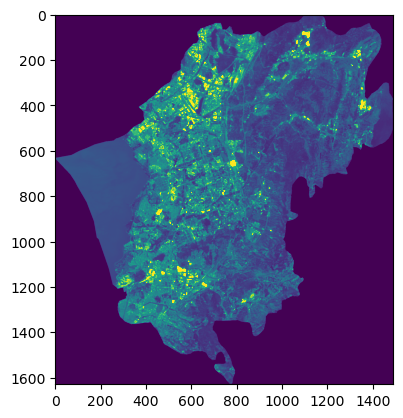

In [67]:
plt.imshow(rsimg_rio.read(1), vmax=2000)


In [68]:
roi_water_utm47 = roi_wat.to_crs(32647) 
roi_veg_utm47 = roi_veg.to_crs(32647)
roi_soil_utm47 = roi_soil.to_crs(32647)
roi_building_utm47 = roi_building.to_crs(32647)


利用roi矢量数据提取样本特征（影像各波段值）。

In [69]:
masked_img_wat, transform_masked_img_wat = mask.mask(
    rsimg_rio, 
    roi_water_utm47.geometry,
    crop=True, 
    nodata=0
)


In [70]:
masked_img_veg, transform_masked_img_veg = mask.mask(
    rsimg_rio, 
    roi_veg_utm47.geometry,
    crop=True, 
    nodata=0
)


In [71]:
masked_img_soil, transform_masked_img_soil = mask.mask(
    rsimg_rio, 
    roi_soil_utm47.geometry,
    crop=True, 
    nodata=0
)

In [72]:
masked_img_building, transform_masked_img_building = mask.mask(
    rsimg_rio, 
    roi_building_utm47.geometry,
    crop=True, 
    nodata=0
)


In [73]:
masked_img_wat[0]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

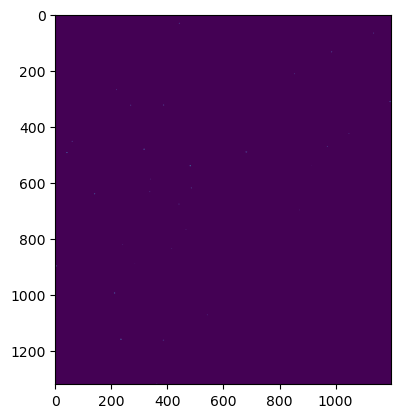

In [74]:
plt.imshow(masked_img_wat[0])


In [75]:
ids_wat = np.where(masked_img_wat[0]>0)
ids_veg = np.where(masked_img_veg[0]>0)
ids_soil = np.where(masked_img_soil[0]>0)
ids_building = np.where(masked_img_building[0]>0)


In [76]:
fea_wat = masked_img_wat[:,ids_wat[0], ids_wat[1]]
fea_veg = masked_img_veg[:,ids_veg[0], ids_veg[1]]
fea_soil = masked_img_soil[:,ids_soil[0], ids_soil[1]]
fea_building = masked_img_building[:,ids_building[0], ids_building[1]]
print('water:',fea_wat.shape)
print('vegetation:',fea_veg.shape)
print('soil:',fea_soil.shape)
print('building:',fea_building.shape)


water: (6, 150)
vegetation: (6, 160)
soil: (6, 143)
building: (6, 182)


In [81]:
### 样本标签数组
label_wat = np.full(shape=fea_wat.shape[1], fill_value=0)
label_veg = np.full(shape=fea_veg.shape[1], fill_value=1)
label_soil = np.full(shape=fea_soil.shape[1], fill_value=2)
label_building = np.full(shape=fea_building.shape[1], fill_value=3)
labels = np.concatenate([label_wat, label_veg, label_soil, label_building])
labels = labels[:,np.newaxis]
labels.shape


(635, 1)

In [83]:
### 分类数据维度: (n_samples, features), 分类标签维度:(n_samples,)
feas = np.concatenate([fea_wat, fea_veg, fea_soil, fea_building], axis=1) 
feas_ = feas.transpose(1,0)
feas_.shape


(635, 6)

In [85]:
sams = np.concatenate([feas_, labels], axis=1)
sams.shape


(635, 7)

In [86]:
path_numpy = 'data/Section-7/sams_array.npy'
np.save(path_numpy, sams)

